In [5]:
# Importe Librerias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, last_day
from IPython.display import display
from PIL import Image
import calendar
import sys
import os
import psycopg2


In [6]:
# Conexión a bd
sys.path.append(os.path.abspath(os.getcwd() + "/.."))

from db_conexion import get_spark_session, write_table, get_postgres_connection

spark = get_spark_session()

print(spark.conf.get("spark.driver.extraClassPath"))


def execute_postgres_query(query):
    conn = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="postgres",
        host="localhost"
    )
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        conn.commit()
    except Exception as e:
        print(f"Error al ejecutar la consulta: {e}")
    finally:
        cur.close()
        conn.close()


def write_table(df, table_name):
    conn = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="postgres",
        host="localhost"
    )
    cur = conn.cursor()

    #print(f"insrt data {df.collect()}")

    # Convertir DataFrame a lista de tuplas para la inserción
    records = [tuple(row) for row in df.collect()]
    columns = ', '.join(df.columns)
    placeholders = ', '.join(['%s'] * len(df.columns))
    
    query = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"

    try:
        cur.executemany(query, records)  # Inserción masiva para mejor rendimiento
        conn.commit()
        print(f"Datos insertados correctamente en '{table_name}'.")
    except Exception as e:
        print(f"Error al insertar datos en '{table_name}': {e}")
    finally:
        cur.close()
        conn.close()


/workspaces/gd-test-bigdata/notebooks/EJERCICIO-1/postgresql-42.7.5.jar


In [7]:
# Generar diccionarios de datos para tablas

clientes_df = spark.read.csv("csv/clientes.csv", header=True, inferSchema=True)
productos_df = spark.read.csv("csv/productos.csv", header=True, inferSchema=True)
corresponsal_df = spark.read.csv("csv/corresponsales.csv", header=True, inferSchema=True)
#print(f"info {corresponsal_df}")
#print(f"info {corresponsal_df.collect()}")
ordenes_df = spark.read.csv("csv/ordenes.csv", header=True, inferSchema=True)
detalles_ordenes_df = spark.read.csv("csv/detalle_orden.csv", header=True, inferSchema=True)

# Convertir fechas a formato adecuado
ordenes_df = ordenes_df.withColumn("fecha", date_format(col("fecha"), "yyyy-MM-dd"))

# Obtener fechas únicas
fechas_unicas = ordenes_df.select("fecha").distinct().collect()

for row in fechas_unicas:
    fecha = row["fecha"]
    año, mes = fecha[:7].split("-")

    ultimo_dia_mes_actual = f"{año}-{mes}-{calendar.monthrange(int(año), int(mes))[1]}"
    mes_inicio = f"{año}-{mes}-01"

    execute_postgres_query(f"""
        CREATE TABLE IF NOT EXISTS ordenes_{fecha[:7].replace('-', '_')} PARTITION OF ordenes
        FOR VALUES FROM ('{mes_inicio}') TO ('{ultimo_dia_mes_actual}'::DATE + INTERVAL '1 day');
    """)

print("Tablas creadas dinámicamente según fechas únicas")




info DataFrame[id: int, nombre: string, direccion: string, telefono: string, email: string, fecha: date]
info [Row(id=1, nombre='Álvaro Plana-Redondo', direccion='Ronda Daro Becerra', telefono='+34974 69 18 21', email='marita23@example.org', fecha=datetime.date(2024, 10, 27)), Row(id=2, nombre='Salomón Gascón', direccion='Calle de Bartolom Oliver', telefono='+34943 329 446', email='jessica54@example.net', fecha=datetime.date(2024, 11, 19)), Row(id=3, nombre='Rubén Diego Uría Téllez', direccion='Camino de Fulgencio Pla', telefono='+34941 94 15 42', email='eoller@example.net', fecha=datetime.date(2024, 8, 21)), Row(id=4, nombre='Loreto Jara', direccion='Ronda de Abril Caas', telefono='+34 988 982 265', email='monicachaves@example.com', fecha=datetime.date(2025, 3, 30)), Row(id=5, nombre='Nicolás Torres Alvarado', direccion='Acceso de Silvestre guila', telefono='+34871 06 22 79', email='pastorzaragoza@example.net', fecha=datetime.date(2024, 9, 6)), Row(id=6, nombre='Emilia Marín Montaña',

Datos insertados correctamente en 'clientes'.
Datos insertados correctamente en 'productos'.
Datos insertados correctamente en 'corresponsales'.
Datos insertados correctamente en 'ordenes'.


Datos insertados correctamente en 'detalles_ordenes'.
Datos insertados correctamente.


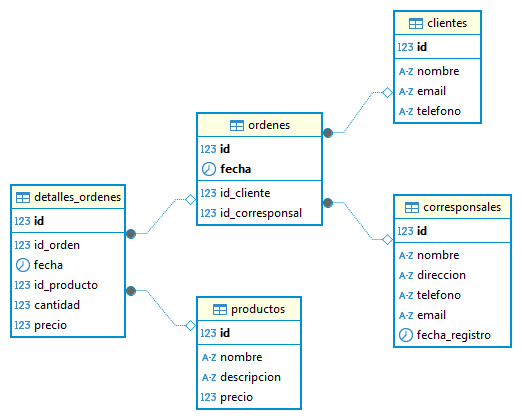

In [8]:
# Insertar datos en base de datos
write_table(clientes_df, "clientes")
write_table(productos_df, "productos")
write_table(corresponsal_df, "corresponsales")
write_table(ordenes_df, "ordenes")


# validar que las fechas existan

ordenes_validas = set(ordenes_df.select("id", "fecha").collect())

detalles_ordenes_df = detalles_ordenes_df.filter(
    (col("id_orden").isin([row.id for row in ordenes_validas])) &
    (col("fecha").isin([row.fecha for row in ordenes_validas]))
)
# end validacion

write_table(detalles_ordenes_df, "detalles_ordenes")


print("Datos insertados correctamente.")



imagen = Image.open("Entidad-Relacion.png")
display(imagen)
